In [ ]:
from google.colab import drive
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage import io, color, filters

In [ ]:
from os.path import isfile, join
import numpy as np
import os
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.util import img_as_float32, img_as_ubyte
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import binary_opening, binary_closing
from skimage.transform import rescale, rotate
from skimage.segmentation import flood_fill

In [ ]:
drive.mount('/content/drive')
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test1_path = '/content/drive/MyDrive/DDMAL/DistCount/test/test1.png'
test2_path = '/content/drive/MyDrive/DDMAL/DistCount/test/test2.png'
test3_path = '/content/drive/MyDrive/DDMAL/DistCount/test/Image.png'

In [ ]:
test1_lines = cv2.cvtColor(cv2.imread(test1_path), cv2.COLOR_RGB2BGR)
test2_gray = cv2.cvtColor(cv2.imread(test2_path), cv2.COLOR_RGB2BGR)

In [ ]:
test1 = io.imread(test3_path) # the general rule of document analysis is to take the median

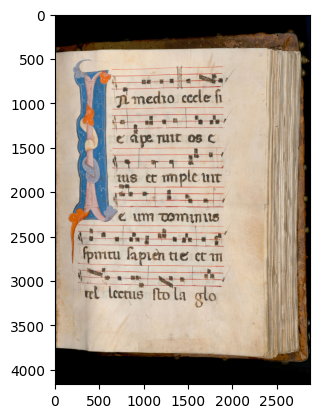

In [ ]:
plt.imshow(test1);

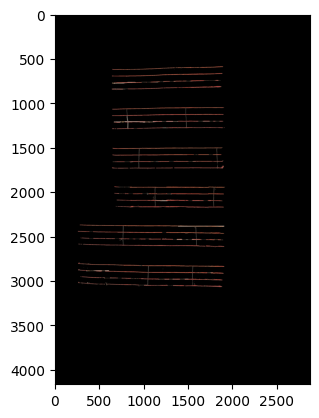

In [ ]:
plt.imshow(test1_lines)

In [ ]:
def fill_corners(input_image, fill_value=0, thresh=1, tol=None, fill_below_thresh=True):

    s = input_image.shape

    if (input_image[0,0] < thresh) == fill_below_thresh:
        input_image = flood_fill(input_image, (0, 0), fill_value, tolerance=tol)
    if (input_image[-1, 0] < thresh) == fill_below_thresh:
        input_image = flood_fill(input_image, (s[0] - 1, 0), fill_value, tolerance=tol)
    if (input_image[0, -1] < thresh) == fill_below_thresh:
        input_image = flood_fill(input_image, (0, s[1] - 1), fill_value, tolerance=tol)

    # This statement would cause the job to hang, but a statement like this could be used for the bottom right corner.
    # if input_image[-1, -1] < thresh:
    #     input_image = flood_fill(input_image, (-1, -1), 1, tolerance=tol)

    return input_image


In [ ]:
def find_rotation_angle(img, coarse_bound=4, fine_bound=0.1, rescale_amt=0.5):
    num_trials = int(coarse_bound / fine_bound)
    img_resized = rescale(img, rescale_amt, order=0, multichannel=False)

    def project_angles(img_to_project, angles_to_try):
        best_angle = 0
        highest_variation = 0
        for a in angles_to_try:
            rot_img = rotate(img_to_project, a, mode='edge')
            proj = np.sum(rot_img, 1).astype('int64')
            variation = np.sum(np.diff(proj) ** 2)
            if variation > highest_variation:
                highest_variation = variation
                best_angle = a
        return best_angle

    angles_to_try = np.linspace(-coarse_bound, coarse_bound, num_trials)
    coarse_angle = project_angles(img_resized, angles_to_try)

    angles_to_try = np.linspace(-fine_bound + coarse_angle, fine_bound + coarse_angle, num_trials)
    fine_angle = project_angles(img_resized, angles_to_try)

    return fine_angle

In [ ]:
def preprocess_images(input_image, soften=5, fill_holes=5):
    # ensure that all points which are transparent have RGB values of 255 (will become white when
    # converted to non-transparent grayscale.)
    input_image = img_as_float32(input_image)
    if len(input_image.shape) == 3 and input_image.shape[2] == 4:
        input_image = rgba2rgb(input_image)
    gray_img = img_as_ubyte(rgb2gray(input_image))

    # get the otsu threshold after running a flood fill on the corners, so that those huge clumps of
    # dark pixels don't mess up the statistics too much (we only care about text!)
    thresh = threshold_otsu(fill_corners(gray_img, fill_value=255, thresh=5, tol=1, fill_below_thresh=True))

    # n.b. here we are setting black pixels from the original image to have a value of 1 (effectively inverting
    # what you would get from a normal binarization, because the math gets easier this way)
    img_bin = img_as_ubyte(gray_img < thresh)
    img_blur_bin = img_as_ubyte(img_as_ubyte(gaussian(gray_img, soften)) < thresh)

    # now, fill corners of binarized images with black (value 0)
    img_bin = fill_corners(img_bin, fill_value=0, thresh=1, tol=1, fill_below_thresh=False)
    img_blur_bin = fill_corners(img_blur_bin, fill_value=0, thresh=1, tol=1, fill_below_thresh=False)

    # run smoothing on the blurred-binarized image so we get blobs of text in neat lines
    kernel = np.ones((fill_holes, fill_holes), np.uint8)
    img_cleaned = binary_opening(binary_closing(img_blur_bin, kernel), kernel)

    # find rotation angle of cleaned, smoothed image. use that to correct the rotation of the unsmoothed image
    angle = find_rotation_angle(img_cleaned)
    img_cleaned_rot = rotate(img_cleaned, angle, order=0, mode='edge') > 0
    img_bin_rot = rotate(img_bin, angle, order=0, mode='edge') > 0

    return img_bin_rot, img_cleaned_rot, angle

In [ ]:
preprocess_images(test1)

KeyboardInterrupt: ignored

In [ ]:
img_bin_rot, img_cleaned_rot, angle = preprocess_images(test1)

<ipython-input-8-a548f2e36bd2>:9: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_resized = rescale(img, rescale_amt, order=0, multichannel=False)


In [ ]:
img_bin_rot2, img_cleaned_rot2, angle2 = preprocess_images(test1_lines)

<ipython-input-31-35850d6aff2a>:3: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_resized = rescale(img, rescale_amt, order=0, multichannel=False)


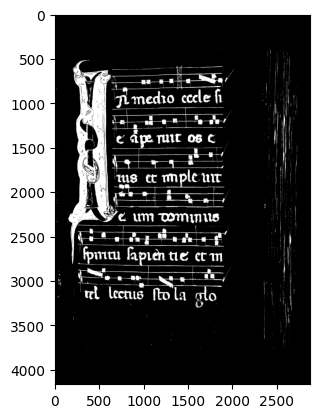

In [ ]:
plt.imshow(img_bin_rot, cmap='gray');

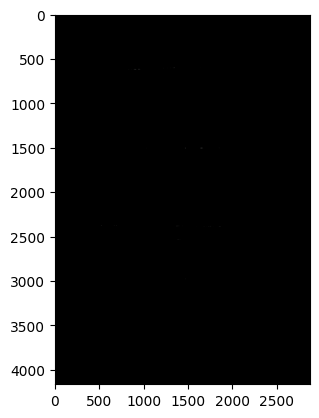

In [ ]:
plt.imshow(img_bin_rot2, cmap='gray')

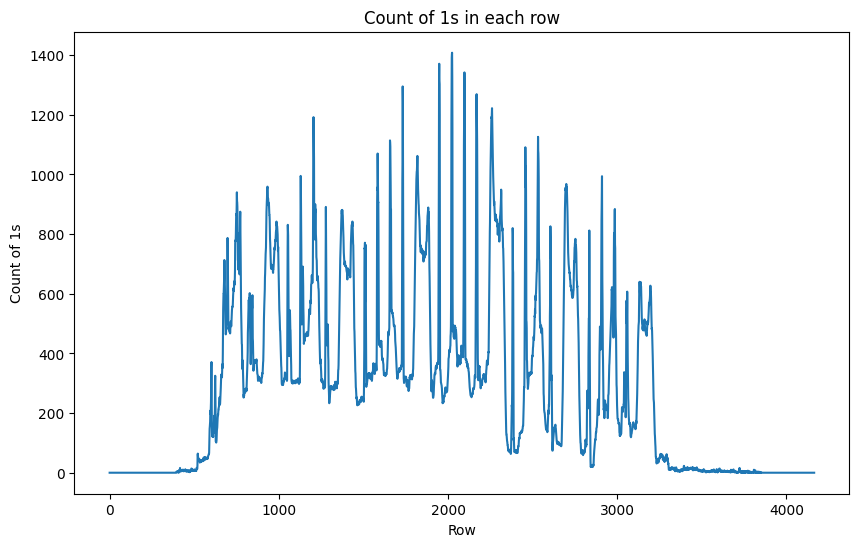

In [ ]:
counts = np.sum(img_bin_rot, axis=1)
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(counts)
plt.xlabel('Row')
plt.ylabel('Count of 1s')
plt.title('Count of 1s in each row')
plt.show()

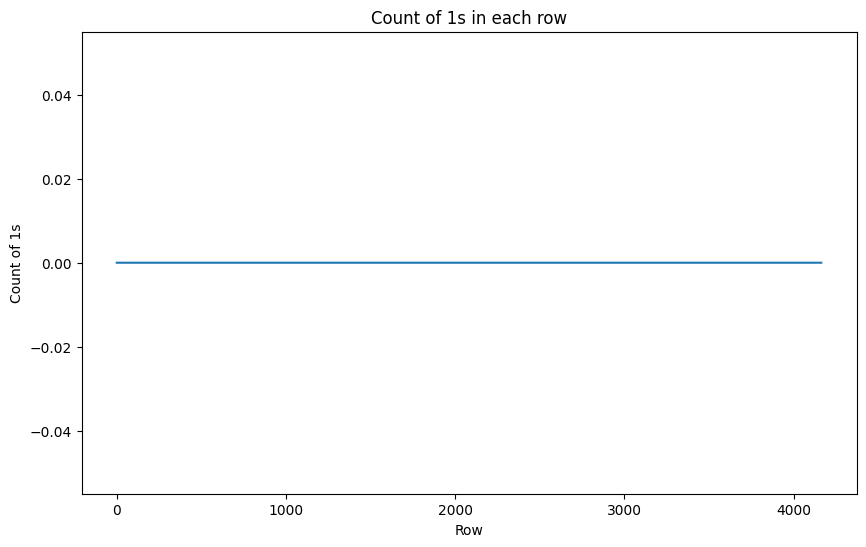

In [ ]:
counts = np.sum(img_cleaned_rot2, axis=1)
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(counts)
plt.xlabel('Row')
plt.ylabel('Count of 1s')
plt.title('Count of 1s in each row')
plt.show()

In [ ]:
counts = np.sum(img_bin_rot, axis=1)
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(counts)
plt.xlabel('Row')
plt.ylabel('Count of 1s')
plt.title('Count of 1s in each row')
plt.show()

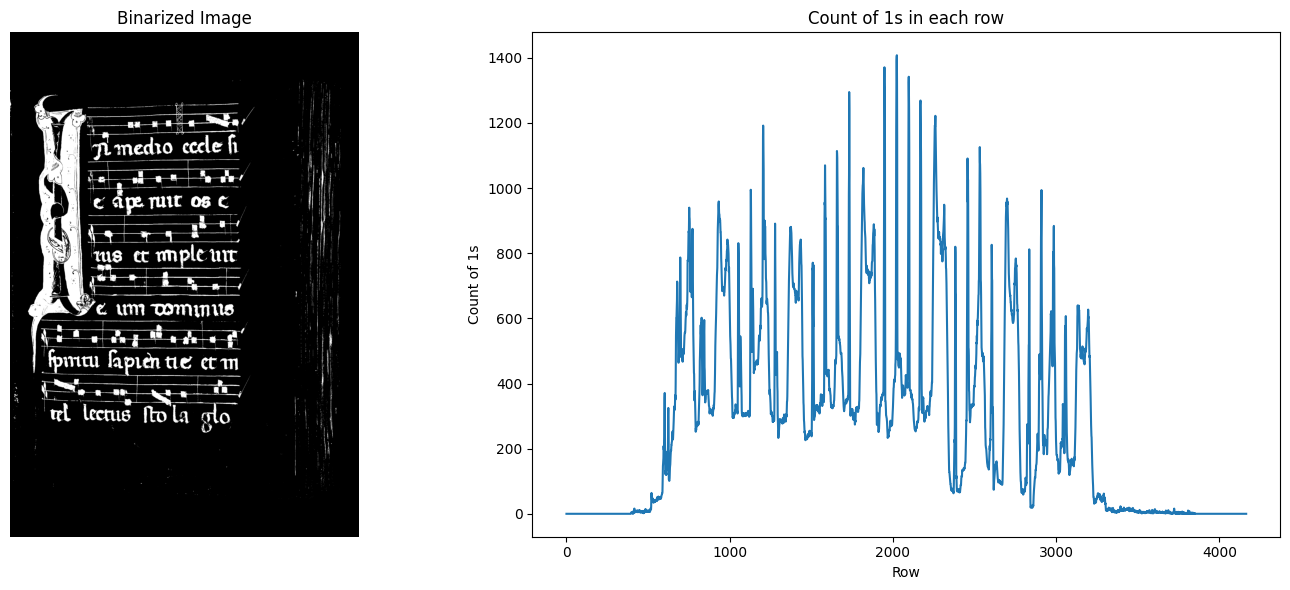

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `img` is your binary image as a numpy array
counts = np.sum(img_bin_rot, axis=1)

plt.figure(figsize=(15, 6))

# Displaying the binary image
plt.subplot(1, 2, 1) # The figure has 1 row, 2 columns, and this plot is the first plot
plt.imshow(img_bin_rot, cmap='gray') # using the 'gray' colormap
plt.title('Binarized Image')
plt.axis('off') # To turn off axes for the image

# Displaying the graph
plt.subplot(1, 2, 2) # The figure has 1 row, 2 columns, and this plot is the second plot.
plt.plot(counts)
plt.xlabel('Row')
plt.ylabel('Count of 1s')
plt.title('Count of 1s in each row')

plt.tight_layout() # To ensure better spacing between the plots
plt.show()
